In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

from data import CHBMITGraph2Vec, CHBMITGraph2Seq

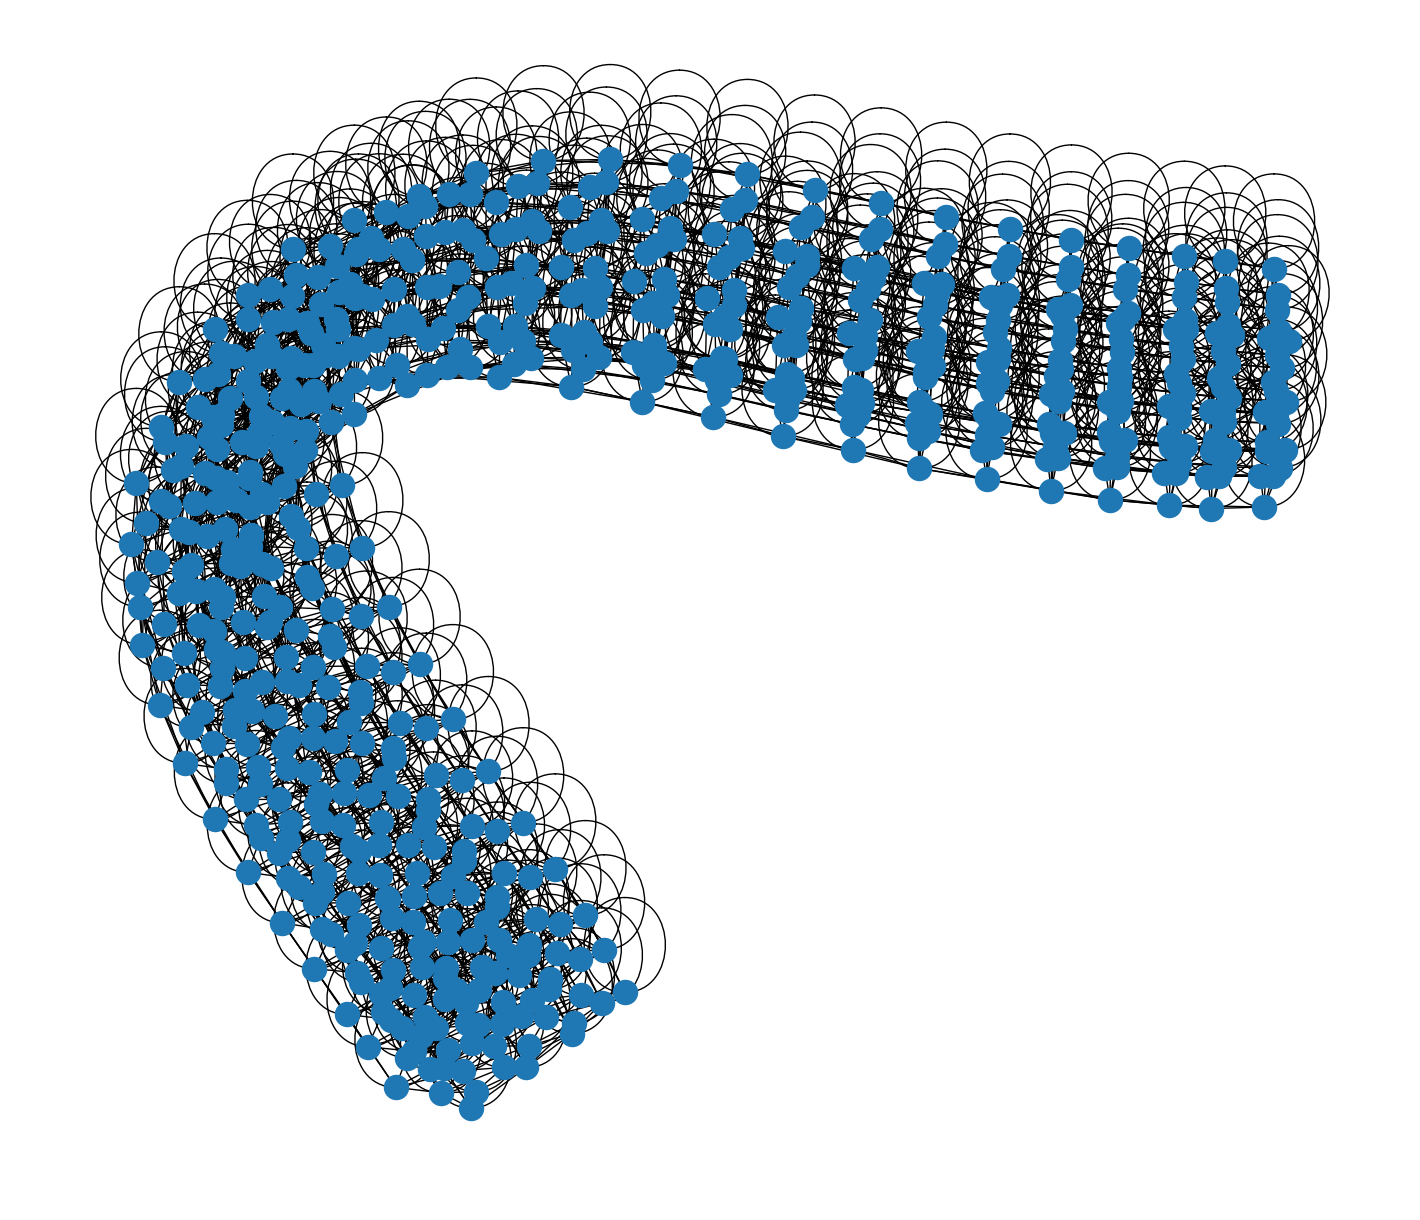

In [11]:
dm = CHBMITGraph2Seq(batch_size=8)
dm.setup("fit")

data = dm.trainset[5]
g = to_networkx(data, to_undirected=True)
plt.figure(1, figsize=(14, 12))
nx.draw(g)
plt.show()